# Module 3: TRD

We want to build a product that relies on a predictive model that allow us to target a set of users that are highly likely to be interested in an item of our choice that we want to promote to send them a push notification. More specifically, we will be developing a machine learning model that, given a user and a product, predicts if the user would purchase it if they were buying with us at that point in time. 

This way, we will be sending push notifications to our users is an effective manner to boost sales and offer discounts to incentivate user engagement with our targeted products without been intrusive and sending too many notifications, since this can generate user disatisfaction and generate churn.

It is worth mentioning that the target impact is to increase our monthly sales by 2% and a boost of 25% over the selected items.

For this product, we have two requirements:
* We are only interested in users that purchase the item along with at least other 4 (minimum 5 items basket)
* The system should allow sales operators to select an item from a dropdown or search bar, get the segment of users to target and trigger a customizable push notification.


## 0. Importing necessary libraries

In [39]:
from pathlib import Path

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, auc, roc_curve
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

from sklearn.preprocessing import StandardScaler



## 1. Data processing

In this dataset, every row representes an (order, product) pair where outcome indicates whether the product was bought or not on that specific order and every other feature has been computed only looking at information prior to that order in order to avoid information leakage.

It is worth remembering that the column outcome indicates, for each order, if a certain product has been bought (for the whole catalogue of products). Therefore, there are lots of 0 outcome instances, and the dataset is imbalanced.

In [40]:
file_path = Path("/mnt/c/Users/Adriana/Desktop/ZRIVE/data/groceries/box_builder_dataset/feature_frame.csv")

# Temporarily adjust the max columns displayed
pd.set_option('display.max_columns', None)

data = pd.read_csv(file_path)
data.head()

,variant_id,product_type,order_id,user_id,created_at,order_date,user_order_seq,outcome,ordered_before,abandoned_before,active_snoozed,set_as_regular,normalised_price,discount_pct,vendor,global_popularity,count_adults,count_children,count_babies,count_pets,people_ex_baby,days_since_purchase_variant_id,avg_days_to_buy_variant_id,std_days_to_buy_variant_id,days_since_purchase_product_type,avg_days_to_buy_product_type,std_days_to_buy_product_type
0,33826472919172,ricepastapulses,2807985930372,3482464092292,2020-10-05 16:46:19,2020-10-05 00:00:00,3,0.0,0.0,0.0,0.0,0.0,0.081052,0.053512,clearspring,0.000000,2.0,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618
1,33826472919172,ricepastapulses,2808027644036,3466586718340,2020-10-05 17:59:51,2020-10-05 00:00:00,2,0.0,0.0,0.0,0.0,0.0,0.081052,0.053512,clearspring,0.000000,2.0,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618
2,33826472919172,ricepastapulses,2808099078276,3481384026244,2020-10-05 20:08:53,2020-10-05 00:00:00,4,0.0,0.0,0.0,0.0,0.0,0.081052,0.053512,clearspring,0.000000,2.0,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618
3,33826472919172,ricepastapulses,2808393957508,3291363377284,2020-10-06 08:57:59,2020-10-06 00:00:00,2,0.0,0.0,0.0,0.0,0.0,0.081052,0.053512,clearspring,0.038462,2.0,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618
4,33826472919172,ricepastapulses,2808429314180,3537167515780,2020-10-06 10:37:05,2020-10-06 00:00:00,3,0.0,0.0,0.0,0.0,0.0,0.081052,0.053512,clearspring,0.038462,2.0,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618


In [41]:
data.shape

(2880549, 27)

In [42]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2880549 entries, 0 to 2880548
Data columns (total 27 columns):
 #   Column                            Dtype  
---  ------                            -----  
 0   variant_id                        int64  
 1   product_type                      object 
 2   order_id                          int64  
 3   user_id                           int64  
 4   created_at                        object 
 5   order_date                        object 
 6   user_order_seq                    int64  
 7   outcome                           float64
 8   ordered_before                    float64
 9   abandoned_before                  float64
 10  active_snoozed                    float64
 11  set_as_regular                    float64
 12  normalised_price                  float64
 13  discount_pct                      float64
 14  vendor                            object 
 15  global_popularity                 float64
 16  count_adults                      fl

In [43]:
information_cols = ['variant_id', 'order_id', 'user_id', 'created_at', 'order_date']
target_col = 'outcome'
feature_cols = [col for col in data.columns if col not in information_cols + [target_col]]

categorical_cols = ['product_type', 'vendor']
binary_cols = ['ordered_before', 'abandoned_before', 'active_snoozed', 'set_as_regular']
numerical_cols = [col for col in feature_cols if col not in categorical_cols + binary_cols]

In [44]:
data['variant_id'] = data['variant_id'].astype('str')
data['order_id'] = data['order_id'].astype('str')
data['user_id'] = data['user_id'].astype('str')

data['created_at'] = data['created_at'].astype('datetime64[us]')
data['order_date'] = data['order_date'].astype('datetime64[us]')

data['outcome'] = data['outcome'].astype(int)

for col in binary_cols:
    data[col] = data[col].astype(int)

# Iterate over each column and check if it starts with 'count_'
for col in data.columns:
    if col.startswith('count_'):
        # Convert the column to integer type
        data[col] = data[col].astype(int)

data['people_ex_baby'] = data['people_ex_baby'].astype('int64')

data['days_since_purchase_variant_id'] = data['days_since_purchase_variant_id'].astype('int64')
data['days_since_purchase_product_type'] = data['days_since_purchase_product_type'].astype('int64')

It is worth mentioning that, since we have being working on this dataset over the latest several weeks, this project skips the Exploratory Data Analysis (EDA) phase as it is already available in previous reports.

## Milestone 1: Exploration Phase
### 1. Building the dataset

#### 1.1 Filtering the data to orders with at least 5 items

Firstly, we filter the data to only those orders with at least 5 items to build a dataset to work with, since they are our target. 

In [45]:
# Group data by order_id and sum the outcome (A product is in the order if its outcome is 1)
order_size = data.groupby('order_id').outcome.sum()

# Identify orders with size at least 5 and extract the order_id of these big orders
big_orders = order_size[order_size >= 5].index 

# Filter data to only include rows where order_id is in the list of big_orders
filtered_data = data.loc[lambda x: x.order_id.isin(big_orders)]

In [46]:
filtered_data.shape

(2163953, 27)

#### 1.2 Splitting the data

In [47]:
# Get how many orders are performed each day
daily_orders = filtered_data.groupby('order_date').order_id.nunique()
daily_orders.head()

order_date
2020-10-05     3
2020-10-06     7
2020-10-07     6
2020-10-08    12
2020-10-09     4
Name: order_id, dtype: int64

Text(0.5, 1.0, 'Daily Orders')

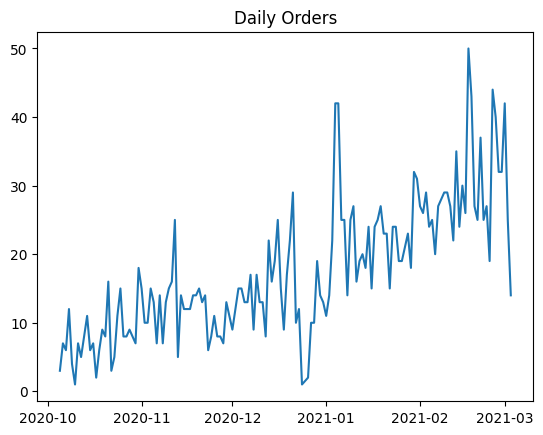

In [48]:
plt.plot(daily_orders, label="Daily orders")
plt.title("Daily Orders")

**Important**: It's evident that there is a significant time-based aspect, signaling changes in patterns and business evolution over time. Consequently, it is prudent to implement a temporal split. This approach not only captures the dynamic nature of the data but also ensures that the same order does not appear in both the training and testing sets, thereby preventing information leakage.

In [49]:
cum_sum_daily_orders = daily_orders.cumsum() / daily_orders.sum()

train_val_cut = cum_sum_daily_orders[cum_sum_daily_orders <= 0.7].idxmax()
val_test_cut = cum_sum_daily_orders[cum_sum_daily_orders <= 0.9].idxmax()

print("Train set from: ", cum_sum_daily_orders.index.min())
print("Train set until: ", train_val_cut)
print("Validation set from: ", val_test_cut)
print("Test set until: ", cum_sum_daily_orders.index.max())

Train set from:  2020-10-05 00:00:00
Train set until:  2021-02-04 00:00:00
Validation set from:  2021-02-22 00:00:00
Test set until:  2021-03-03 00:00:00


It is important to consider what is the minimum business cicle, that is, the minimum temporal window that allows us to capture the complete dynamics of the data we want to model. Even though the validation and test splits don't comprise many days, we consider these should be sufficient for our case.

In [50]:
train_data = filtered_data[filtered_data.order_date <= train_val_cut]
val_data = filtered_data[(filtered_data.order_date > train_val_cut) & (filtered_data.order_date <= val_test_cut) ]
test_data = filtered_data[filtered_data.order_date > val_test_cut]

Divide into features and target:

In [51]:
def feature_target_split(df, target):
    X = df.drop(columns=[target])  # Drop the target column to create the features DataFrame
    Y = df[target]   # Target variable we want to predict
    return X, Y

X_train, Y_train = feature_target_split(train_data, target_col)
X_val, Y_val = feature_target_split(val_data, target_col)
X_test, Y_test = feature_target_split(test_data, target_col)

### 2. Defining a Baseline model

In order to be able to decide if a ML model generates any value, we need to compare it against baselines that do not require training. In this case, we will use the global popularity feature as baseline, that is, the product will be predicted to be bought the more popular it is.

In [52]:
def plot_curves(y_true, y_pred, curve_type="both", dataset_type="train"):
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    fig.suptitle(f"{dataset_type.capitalize()} Dataset - Performance Curves")

    if curve_type in ["precision-recall", "both"]:
        # Compute the precision-recall curve and its AUC
        precision, recall, _ = precision_recall_curve(y_true, y_pred)
        pr_auc = auc(recall, precision)
        
        axes[0].step(recall, precision)
        axes[0].set_xlabel('Recall')
        axes[0].set_ylabel('Precision')
        axes[0].set_title(f'Precision-Recall Curve (AUC={pr_auc:.2f})')

    if curve_type in ["roc", "both"]:
        # Compute the ROC curve and its AUC
        fpr, tpr, _ = roc_curve(y_true, y_pred)
        roc_auc = auc(fpr, tpr)

        axes[1].plot(fpr, tpr)
        axes[1].set_xlabel('False Positive Rate')
        axes[1].set_ylabel('True Positive Rate')
        axes[1].set_title(f'ROC Curve (AUC={roc_auc:.2f})')

    plt.tight_layout()
    plt.show()


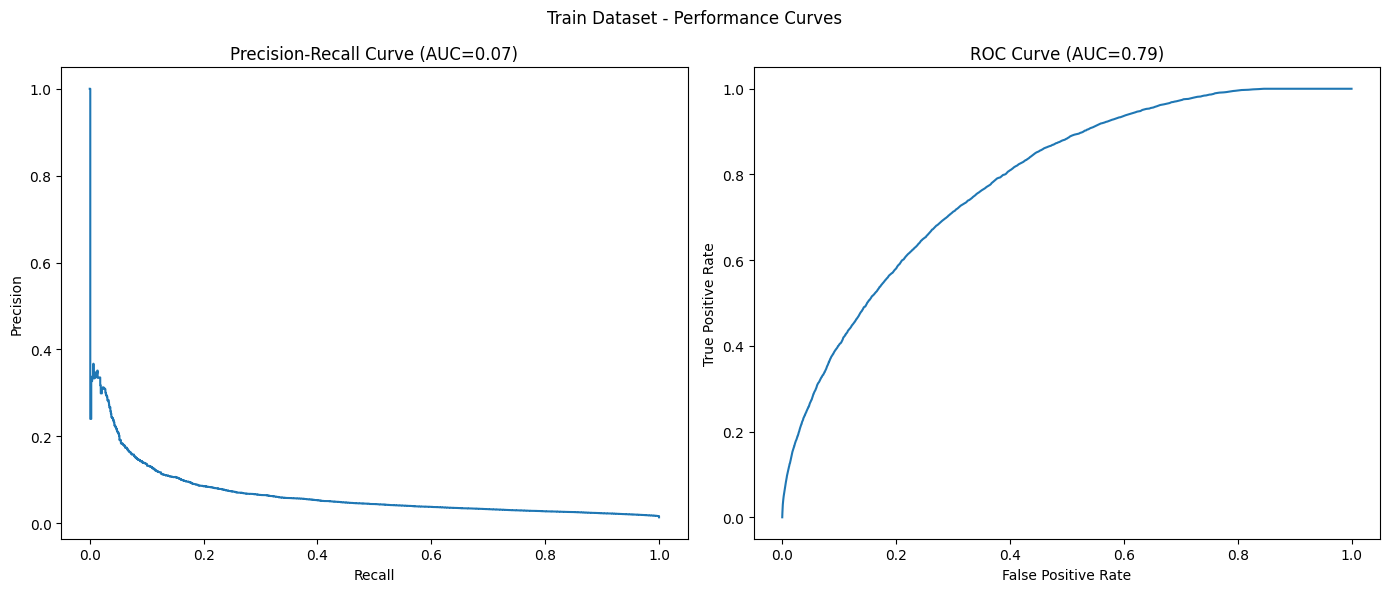

In [53]:
y_pred = val_data['global_popularity']
y_true = val_data['outcome']


plot_curves(y_true, y_pred, curve_type="both", dataset_type="train")


### 3. Training an initial model with only numerical variables
I will be trainning a logistic regression model as the target variable is binary.
Additionally, I start by training some initial models that do not need preprocessing, that is, with only numerical (and binary) variables. 

In [54]:
train_cols = numerical_cols + binary_cols

#### 3.1 Ridge Regression

**Important:** Before training the Ridge Regression model, it is crucial to standardize the data, ensuring each column has a mean of 0 and a standard deviation of 1. This standardization makes all features comparable, giving equal importance to each one in the model. This practice prevents variables with larger scales from disproportionately influencing the model's predictions due to their scale rather than their relevance. Additionally, standardizing the data helps in achieving faster and more stable convergence of the regression algorithm.

In [55]:
# First, standardize the data
scaler = StandardScaler()

# Fit the scaler on the training data and transform it
X_train_scaled = scaler.fit_transform(X_train[train_cols])


# Apply the same transformation to the validation data
X_val_scaled = scaler.transform(X_val[train_cols])


In [56]:
def plot_curves_with_hyperparameter(ax, y_true, y_pred, label, curve_type="both"):
    if curve_type in ["precision-recall", "both"]:
        # Compute the precision-recall curve and its AUC
        precision, recall, _ = precision_recall_curve(y_true, y_pred)
        pr_auc = auc(recall, precision)
        
        ax[0].step(recall, precision, label=f'{label} (AUC={pr_auc:.2f})')
        ax[0].set_xlabel('Recall')
        ax[0].set_ylabel('Precision')
        ax[0].set_title('Precision-Recall Curve')

    if curve_type in ["roc", "both"]:
        # Compute the ROC curve and its AUC
        fpr, tpr, _ = roc_curve(y_true, y_pred)
        roc_auc = auc(fpr, tpr)
        
        ax[1].plot(fpr, tpr, label=f'{label} (AUC={roc_auc:.2f})')
        ax[1].set_xlabel('False Positive Rate')
        ax[1].set_ylabel('True Positive Rate')
        ax[1].set_title('ROC Curve')

/tmp/ipykernel_82778/2186894484.py:39: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig_train.show()
/tmp/ipykernel_82778/2186894484.py:40: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig_val.show()


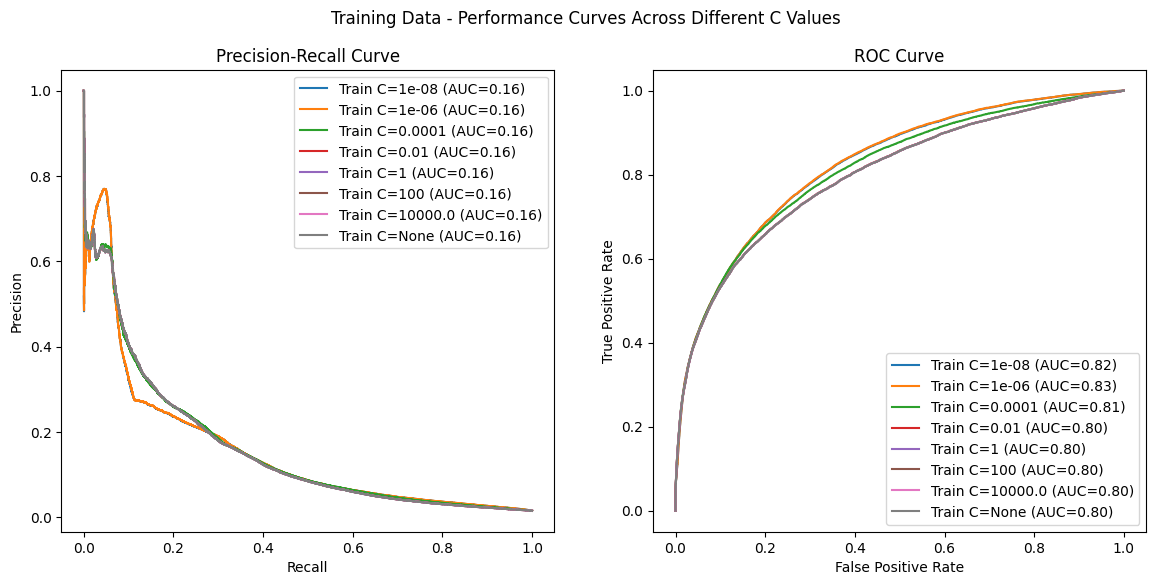

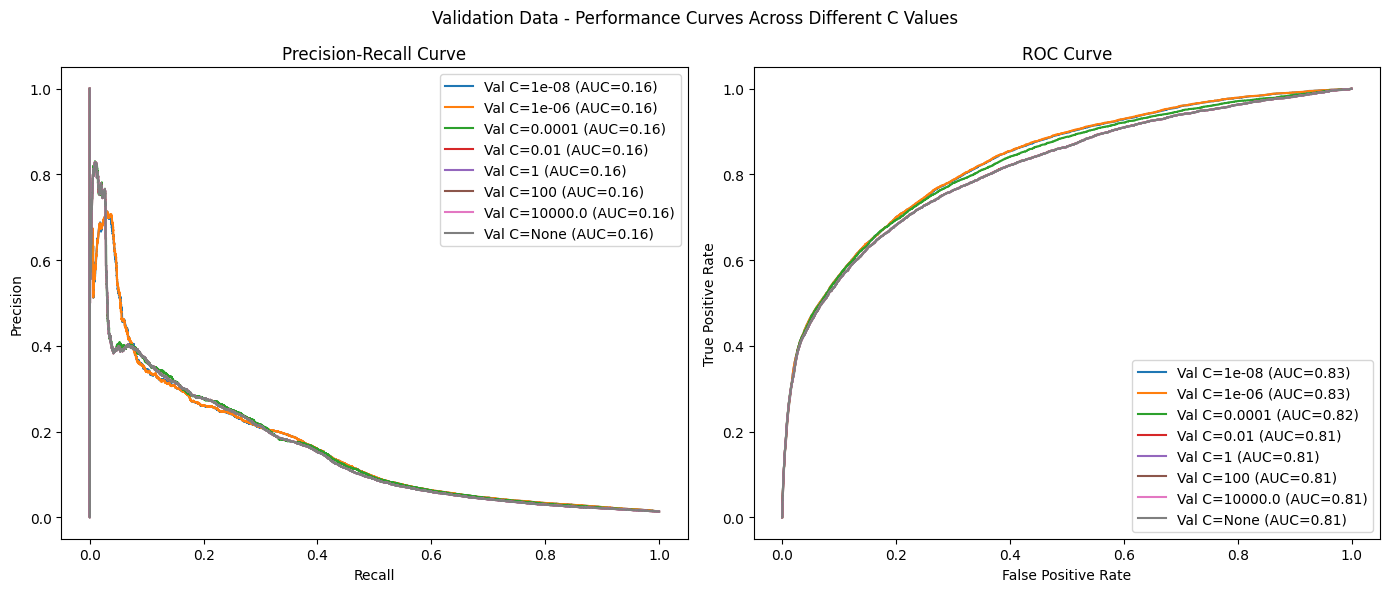

In [57]:
# Train the Logistic Regression model

# Prepare the plot environments for both training and validation
fig_train, axes_train = plt.subplots(1, 2, figsize=(14, 6))
fig_train.suptitle('Training Data - Performance Curves Across Different C Values')
fig_val, axes_val = plt.subplots(1, 2, figsize=(14, 6))
fig_val.suptitle('Validation Data - Performance Curves Across Different C Values')


# Define hyperparameter for the level of regularization
cs = [1e-8, 1e-6, 1e-4, 1e-2, 1, 100, 1e4, None]


for c in cs:
    if c == None:
        lr = LogisticRegression(penalty = None)
    else:
        lr = LogisticRegression(penalty='l2', C=c)
    
    # Fit the model on scaled training data
    lr.fit(X_train_scaled, Y_train)

    # Predict probabilities for the positive class on the training set
    train_proba = lr.predict_proba(X_train_scaled)[:, 1]
    plot_curves_with_hyperparameter(axes_train, Y_train, train_proba, f'Train C={c}', curve_type="both")


    # Predict probabilities for the positive class on the validation set
    val_proba = lr.predict_proba(X_val_scaled)[:, 1]
    plot_curves_with_hyperparameter(axes_val, Y_val, val_proba, f'Val C={c}', curve_type="both")

# Add legends and show plots
axes_train[0].legend(loc='upper right')
axes_train[1].legend(loc='lower right')
axes_val[0].legend(loc='upper right')
axes_val[1].legend(loc='lower right')

plt.tight_layout()
fig_train.show()
fig_val.show()

Firstly, our analysis indicates that regularization does not enhance the performance of our model. Both the ROC and precision-Recall curves, along with their respective areas under the curve (AUC), demonstrate consistent results across various regularization strengths. This consistency suggests that the existing complexity of the model is well-suited to our task, as the introduction of regularization does not yield measurable improvements. The lack of performance variance with different levels of regularization implies that the model's complexity is already optimal, negating the need for further regularization adjustments.

Furthermore, it is worth mentioning that our dataset is significantly imbalanced, as previously mentioned, with a predominance of negative examples. This imbalance skews the False Positive Rate (FPR), which remains deceptively low even when the absolute number of false positives is substantial. In contrast, the Precision-Recall curves are more revealing, demonstrating notable improvements over the baseline.

Finally, comparing the model’s performance on training and validation datasets reveals similar error rates, suggesting effective generalization to new data. This consistency confirms that the model is not overfitting; it is not merely memorizing the training data or modelling its noise, but is learning to generalize from it.

#### 3.2 Lasso Regression


/tmp/ipykernel_82778/1816860315.py:39: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig_train.show()
/tmp/ipykernel_82778/1816860315.py:40: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig_val.show()


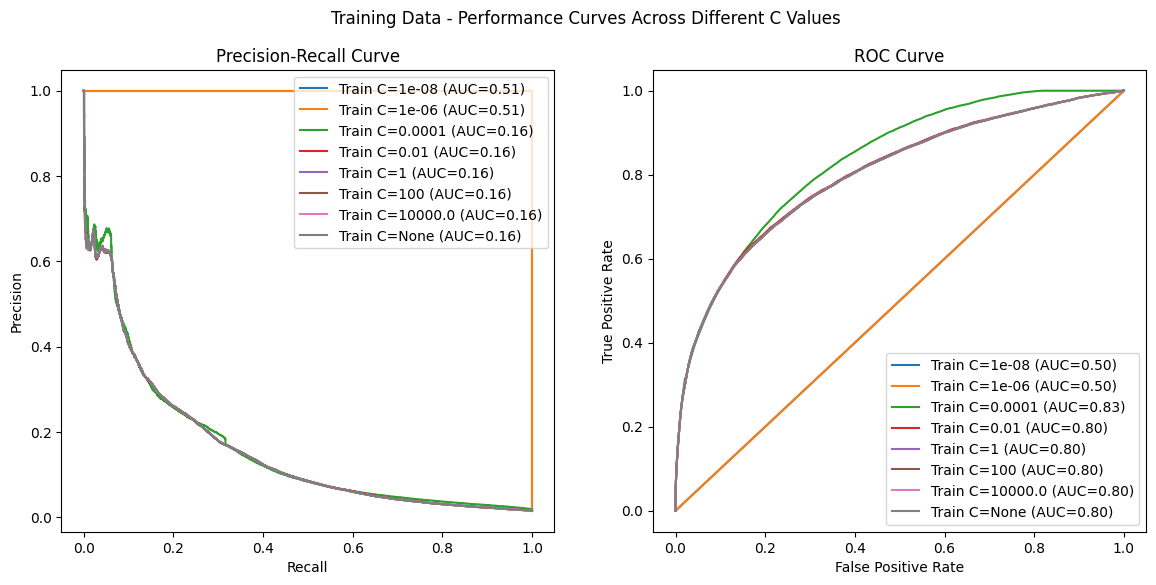

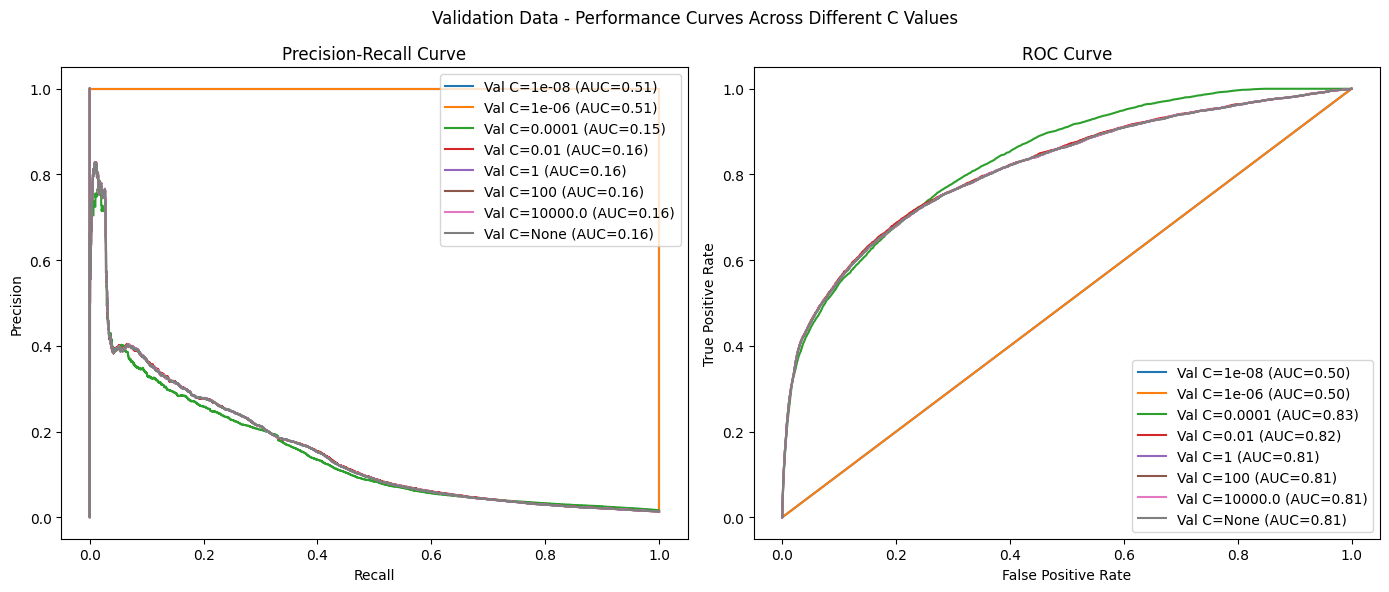

In [58]:
# Train the Logistic Regression model

# Prepare the plot environments for both training and validation
fig_train, axes_train = plt.subplots(1, 2, figsize=(14, 6))
fig_train.suptitle('Training Data - Performance Curves Across Different C Values')
fig_val, axes_val = plt.subplots(1, 2, figsize=(14, 6))
fig_val.suptitle('Validation Data - Performance Curves Across Different C Values')


# Define hyperparameter for the level of regularization
cs = [1e-8, 1e-6, 1e-4, 1e-2, 1, 100, 1e4, None]


for c in cs:
    if c == None:
        lr = LogisticRegression(penalty = None)
    else:
        lr = LogisticRegression(penalty='l1', C=c, solver="saga")
    
    # Fit the model on scaled training data
    lr.fit(X_train_scaled, Y_train)

    # Predict probabilities for the positive class on the training set
    train_proba = lr.predict_proba(X_train_scaled)[:, 1]
    plot_curves_with_hyperparameter(axes_train, Y_train, train_proba, f'Train C={c}', curve_type="both")


    # Predict probabilities for the positive class on the validation set
    val_proba = lr.predict_proba(X_val_scaled)[:, 1]
    plot_curves_with_hyperparameter(axes_val, Y_val, val_proba, f'Val C={c}', curve_type="both")

# Add legends and show plots
axes_train[0].legend(loc='upper right')
axes_train[1].legend(loc='lower right')
axes_val[0].legend(loc='upper right')
axes_val[1].legend(loc='lower right')

plt.tight_layout()
fig_train.show()
fig_val.show()

This time, with Lasso regression, we can observe that for the Precision-Recall plot indicates that the model works best for $c=10^{-8}$ and $c=10^{-6}$ the model performs the best, as it contais a higher AUC. Nevertheless, when looking at the ROC curve, we can observe that these values provide the lowest AUC. Therefore, the level of regularization does not seem to make a great impact. 

Additionally, we can observe that the performance is similar to Ridge.

Disclaimer: it is worth mentioning that the Precision-Recall curve for $c=10^{-6}$ does not seem correct, as it does not match with its corresponding AUC.

### 3.3. Coefficients weights

In [59]:
c_l2 = 10e-6
lr = LogisticRegression(penalty='l2', C=c_l2)
lr.fit(X_train_scaled, Y_train)

lr_coefs_l2 = pd.DataFrame({"features": train_cols, 
                            "importance": np.abs(lr.coef_[0]), 
                            "regularisation" : ["l2"]*len(train_cols)})

lr_coefs_l2 = lr_coefs_l2.sort_values('importance', ascending=True)

c_l1 = 10e-4
lr = LogisticRegression(penalty='l1', C=c_l1,  solver="saga")
lr.fit(X_train_scaled, Y_train)

lr_coefs_l1 = pd.DataFrame({"features": train_cols, 
                            "importance": np.abs(lr.coef_[0]), 
                            "regularisation" : ["l1"]*len(train_cols)})

lr_coefs_l1 = lr_coefs_l1.sort_values('importance', ascending=True)

<Axes: xlabel='importance', ylabel='features'>

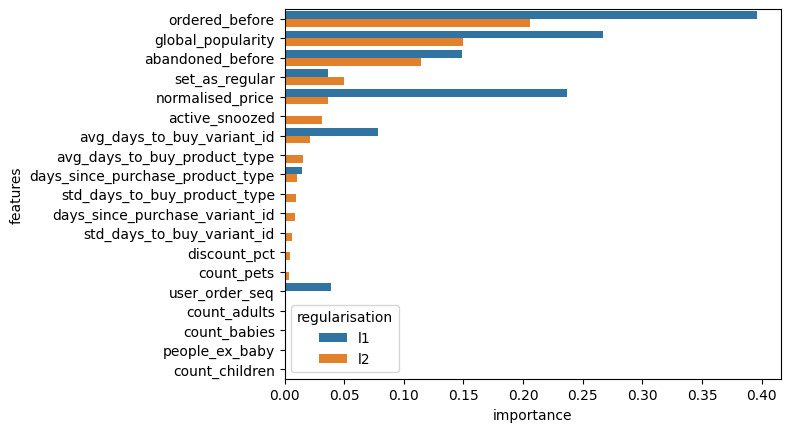

In [60]:
lr_coefs = pd.concat([lr_coefs_l1, lr_coefs_l2])
lr_coefs["features"] = pd.Categorical(lr_coefs["features"])

# Sort again
lr_coefs = lr_coefs.sort_values('importance', ascending=True)
order_cols = lr_coefs_l2.sort_values('importance', ascending=False)["features"]

sns.barplot(lr_coefs, x="importance", y="features", hue="regularisation", order=order_cols)

we can observe that, as expected, L1 and L2 have different behaviour regarding how many features are assigned $\beta = 0$. Lasso (L1) has 6 variables, as it tends to give 0 weights, whereas Ridge has more variables with lower weights. Since we can observe that several features are not relevant, as they are assigned 0 (or very low) weights, we will train a model only with the significant ones.

### 4. Training models with only a subset of features

In [61]:
reduced_cols = ['ordered_before', 'global_popularity', 'abandoned_before', 'normalised_price']
X_train_reduced_scaled = scaler.fit_transform(X_train[reduced_cols])
X_val_reduced_scaled = scaler.fit_transform(X_val[reduced_cols])

/tmp/ipykernel_82778/2610710267.py:50: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig_train.show()
/tmp/ipykernel_82778/2610710267.py:51: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig_val.show()


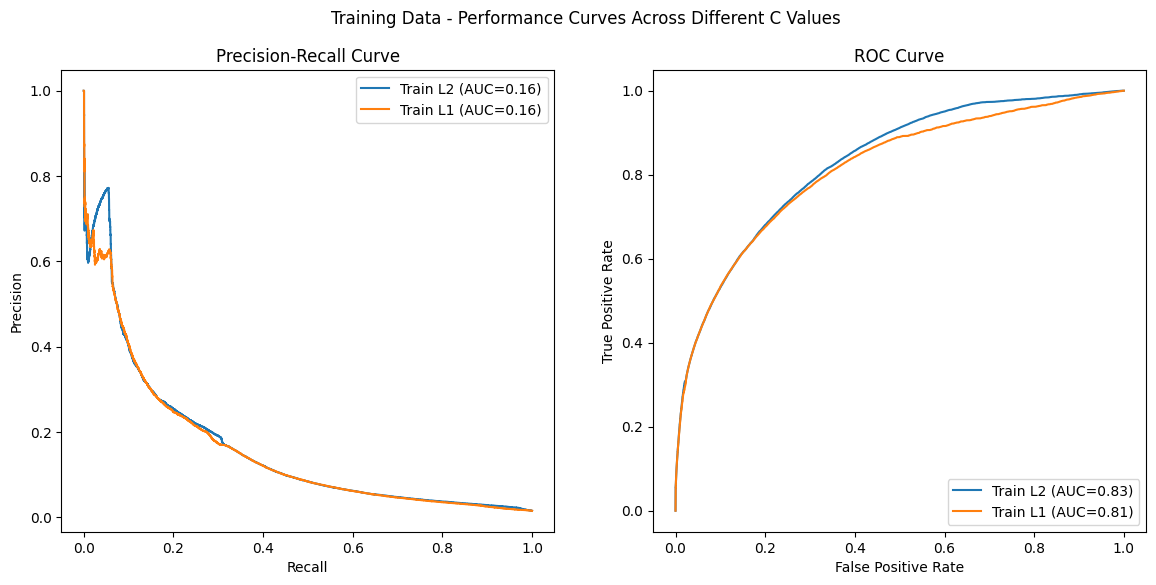

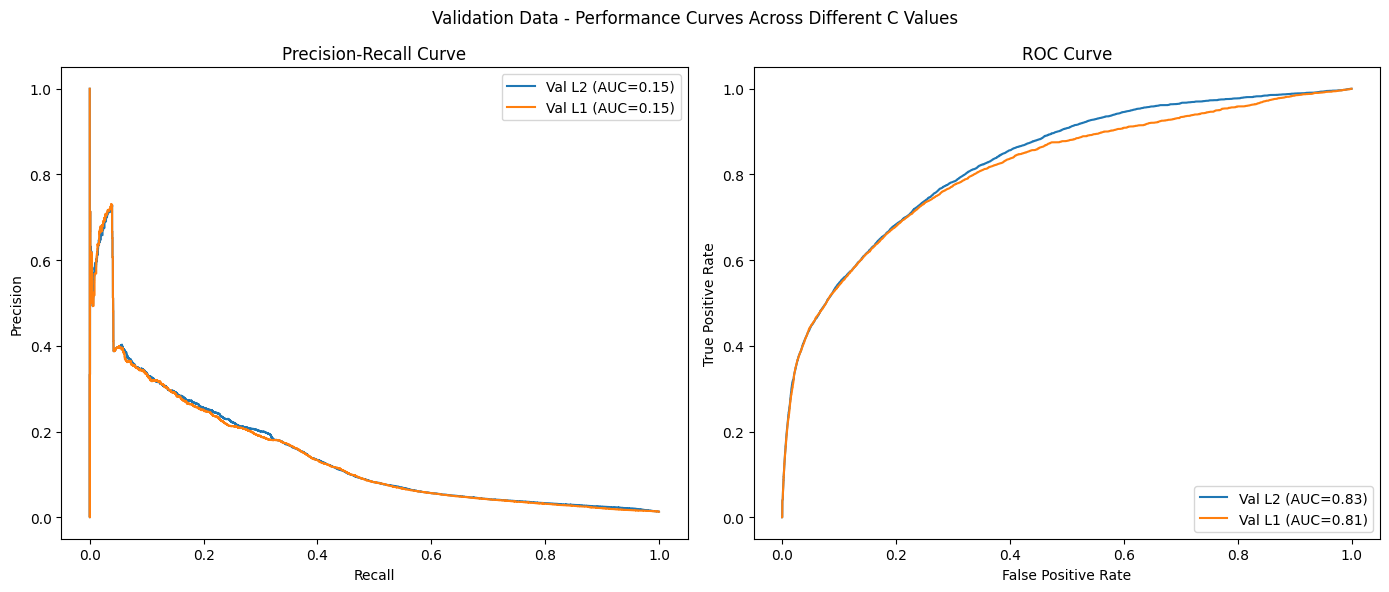

In [62]:
# Train the Logistic Regression model

# Prepare the plot environments for both training and validation
fig_train, axes_train = plt.subplots(1, 2, figsize=(14, 6))
fig_train.suptitle('Training Data - Performance Curves Across Different C Values')
fig_val, axes_val = plt.subplots(1, 2, figsize=(14, 6))
fig_val.suptitle('Validation Data - Performance Curves Across Different C Values')


## L2
# Define hyperparameter for the level of regularization
c_l2 = 10e-6

lr2 = LogisticRegression(penalty='l2', C=c_l2)

# Fit the model on scaled training data
lr2.fit(X_train_reduced_scaled, Y_train)

# Predict probabilities for the positive class on the training set
train_proba2 = lr2.predict_proba(X_train_reduced_scaled)[:, 1]
plot_curves_with_hyperparameter(axes_train, Y_train, train_proba2, 'Train L2', curve_type="both")

# Predict probabilities for the positive class on the validation set
val_proba2 = lr2.predict_proba(X_val_reduced_scaled)[:, 1]
plot_curves_with_hyperparameter(axes_val, Y_val, val_proba2, 'Val L2', curve_type="both")

## L1
c_l1 = 10e-4
lr1 = LogisticRegression(penalty='l1', C=c_l1, solver="saga")
    
# Fit the model on scaled training data
lr1.fit(X_train_reduced_scaled, Y_train)

# Predict probabilities for the positive class on the training set
train_proba1 = lr1.predict_proba(X_train_reduced_scaled)[:, 1]
plot_curves_with_hyperparameter(axes_train, Y_train, train_proba1, 'Train L1', curve_type="both")

# Predict probabilities for the positive class on the validation set
val_proba1 = lr1.predict_proba(X_val_reduced_scaled)[:, 1]
plot_curves_with_hyperparameter(axes_val, Y_val, val_proba1, 'Val L1', curve_type="both")


# Add legends and show plots
axes_train[0].legend(loc='upper right')
axes_train[1].legend(loc='lower right')
axes_val[0].legend(loc='upper right')
axes_val[1].legend(loc='lower right')

plt.tight_layout()
fig_train.show()
fig_val.show()

We can see that the model's performance remains consistent with previous outcomes, despite using only a limited set of variables for both models.

### 5. Training a model with categorical variables

#### Addressing categorical variables
Logistic regression models in libraries like Scikit-learn expect all input features to be numeric. Therefore, categorical variables need to be converted into a numerical format before they can be used for model training. It is worth remembering that we do not consider variant_id, order_id, and user_id categorical variables, but informative ones, and these will not be used to train the model.

First, deal with the two datetime columns. For created_at, I split the information of these into four columns: for year, month, day and hour. On the other hand, since order_date does not contain any additional information, I remove it.

In [63]:
def transform_datetime(df, date_col):
    """
    Transforms a datetime column into the following extracted components: year, month, day, and hour.
    
    Input parameters:
    df (pd.DataFrame): The DataFrame containing the datetime column.
    date_col (datetome): The name of the datetime column to transform.
    
    Returns:
    pd.DataFrame: The modified DataFrame with new columns for date components.
    """

    # Check if the column exists in the DataFrame
    if date_col not in df.columns:
        raise ValueError(f"The column {date_col} does not exist in the DataFrame.")
    
    # Extracting components
    df[f'{date_col}_year'] = df[date_col].dt.year
    df[f'{date_col}_month'] = df[date_col].dt.month
    df[f'{date_col}_day'] = df[date_col].dt.day
    df[f'{date_col}_hour'] = df[date_col].dt.hour
    
    # Remove the original datetime column
    df = df.drop(columns=[date_col])
    
        
    return df

In [64]:
extended_cols = reduced_cols + categorical_cols + ['created_at']
X_train_cat = X_train[extended_cols]
X_val_cat = X_val[extended_cols]

# Transform created_at column
X_train_cat = transform_datetime(X_train_cat, 'created_at')
X_val_cat = transform_datetime(X_val_cat, 'created_at')
   
print(X_train_cat.shape)
X_train_cat.head()

/tmp/ipykernel_82778/969680544.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'{date_col}_year'] = df[date_col].dt.year
/tmp/ipykernel_82778/969680544.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'{date_col}_month'] = df[date_col].dt.month
/tmp/ipykernel_82778/969680544.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

(1426520, 10)


/tmp/ipykernel_82778/969680544.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'{date_col}_year'] = df[date_col].dt.year
/tmp/ipykernel_82778/969680544.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'{date_col}_month'] = df[date_col].dt.month
/tmp/ipykernel_82778/969680544.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

,ordered_before,global_popularity,abandoned_before,normalised_price,product_type,vendor,created_at_year,created_at_month,created_at_day,created_at_hour
0,0,0.000000,0,0.081052,ricepastapulses,clearspring,2020,10,5,16
1,0,0.000000,0,0.081052,ricepastapulses,clearspring,2020,10,5,17
2,0,0.000000,0,0.081052,ricepastapulses,clearspring,2020,10,5,20
3,0,0.038462,0,0.081052,ricepastapulses,clearspring,2020,10,6,8
5,0,0.038462,0,0.081052,ricepastapulses,clearspring,2020,10,6,10


Now, for the categorical variables (product_type and vendor), which are strings, my first idea was to use Dummy variables for all, which are similar to one-hot encoding but avoids one redundant category by dropping the first category.

But first, I check how many categories each column contains to address if it is feasable to do dummy variables or if too many columns would be created.

In [65]:
for col in categorical_cols:
    print("Number of cateogories in: ", col, ": ", len(X_train_cat[col].unique()))  # Returns array of unique values


Number of cateogories in:  product_type :  59
Number of cateogories in:  vendor :  240


We can observe that the only column where using the Dummy variables approach may be feasible is for product_type. Furthermore, since  vendor would create too many columns with this approach (as it has many different variables), I try One Hot encoder (with colisions).

In [66]:
"""# Initialize OneHotEncoder
OHE = OneHotEncoder(max_categories=25, sparse_output=False)  

X_train_encoded = pd.DataFrame(index=X_train_cat.index)

for col in categorical_cols:
    # Fit and transform data
    encoded_data = OHE.fit_transform(X_train_cat[[col]])
    
    # Get categories for the current column from the encoder
    categories = OHE.categories_[0]
    
    # Create column names for the encoded features
    col_names = [f"{col}_{category}" for category in categories]
    
    # Ensure the DataFrame is created with matching number of columns
    encoded_df = pd.DataFrame(encoded_data, columns=col_names, index=X_train_cat.index)
    
    # Concatenate the new DataFrame to the existing DataFrame
    X_train_encoded = pd.concat([X_train_encoded, encoded_df], axis=1)"""


'# Initialize OneHotEncoder\nOHE = OneHotEncoder(max_categories=25, sparse_output=False)  \n\nX_train_encoded = pd.DataFrame(index=X_train_cat.index)\n\nfor col in categorical_cols:\n    # Fit and transform data\n    encoded_data = OHE.fit_transform(X_train_cat[[col]])\n    \n    # Get categories for the current column from the encoder\n    categories = OHE.categories_[0]\n    \n    # Create column names for the encoded features\n    col_names = [f"{col}_{category}" for category in categories]\n    \n    # Ensure the DataFrame is created with matching number of columns\n    encoded_df = pd.DataFrame(encoded_data, columns=col_names, index=X_train_cat.index)\n    \n    # Concatenate the new DataFrame to the existing DataFrame\n    X_train_encoded = pd.concat([X_train_encoded, encoded_df], axis=1)'

In [67]:
# Label Encoding
label_encoder = {}
for col in categorical_cols:
    le = LabelEncoder()
    X_train_cat[col] = le.fit_transform(X_train_cat[col])
    X_val_cat[col] = le.fit_transform(X_val_cat[col])
    label_encoder[col] = le  # Store the label encoder for each column

# Concatenate with non-categorical features
non_categorical_cols = [col for col in X_train_cat.columns if col not in categorical_cols]
X_train_final = pd.concat([X_train_cat[non_categorical_cols], X_train_cat], axis=1)
X_val_final = pd.concat([X_val_cat[non_categorical_cols], X_val_cat], axis=1)

X_train_final.head()

,ordered_before,global_popularity,abandoned_before,normalised_price,created_at_year,created_at_month,created_at_day,created_at_hour,ordered_before,global_popularity,abandoned_before,normalised_price,product_type,vendor,created_at_year,created_at_month,created_at_day,created_at_hour
0,0,0.000000,0,0.081052,2020,10,5,16,0,0.000000,0,0.081052,46,44,2020,10,5,16
1,0,0.000000,0,0.081052,2020,10,5,17,0,0.000000,0,0.081052,46,44,2020,10,5,17
2,0,0.000000,0,0.081052,2020,10,5,20,0,0.000000,0,0.081052,46,44,2020,10,5,20
3,0,0.038462,0,0.081052,2020,10,6,8,0,0.038462,0,0.081052,46,44,2020,10,6,8
5,0,0.038462,0,0.081052,2020,10,6,10,0,0.038462,0,0.081052,46,44,2020,10,6,10


/tmp/ipykernel_82778/1566344662.py:33: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig_train.show()
/tmp/ipykernel_82778/1566344662.py:34: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig_val.show()


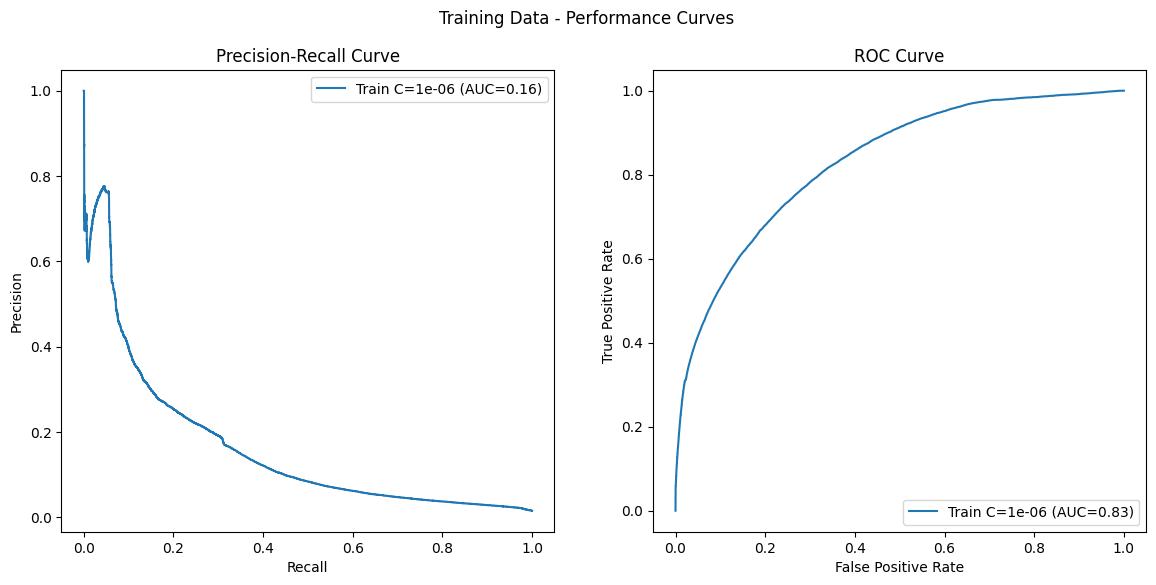

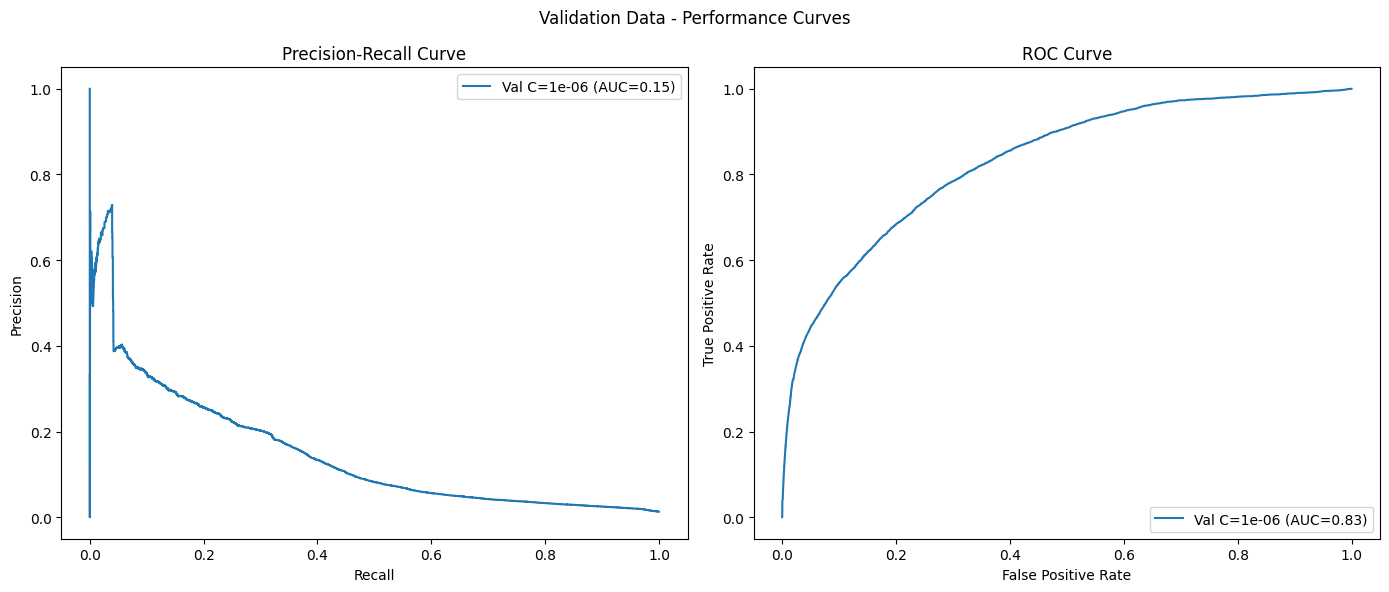

In [68]:
# Train the Logistic Regression model
X_train_final_scaled = scaler.fit_transform(X_train_final[reduced_cols])
X_val_final_scaled = scaler.fit_transform(X_val_final[reduced_cols])

# Prepare the plot environments for both training and validation
fig_train, axes_train = plt.subplots(1, 2, figsize=(14, 6))
fig_train.suptitle('Training Data - Performance Curves')
fig_val, axes_val = plt.subplots(1, 2, figsize=(14, 6))
fig_val.suptitle('Validation Data - Performance Curves')

c = 1e-6
lr = LogisticRegression(penalty='l2', C=c)

# Fit the model on scaled training data
lr.fit(X_train_final_scaled, Y_train)

# Predict probabilities for the positive class on the training set
train_proba = lr.predict_proba(X_train_final_scaled)[:, 1]
plot_curves_with_hyperparameter(axes_train, Y_train, train_proba, f'Train C={c}', curve_type="both")


# Predict probabilities for the positive class on the validation set
val_proba = lr.predict_proba(X_val_final_scaled)[:, 1]
plot_curves_with_hyperparameter(axes_val, Y_val, val_proba, f'Val C={c}', curve_type="both")

# Add legends and show plots
axes_train[0].legend(loc='upper right')
axes_train[1].legend(loc='lower right')
axes_val[0].legend(loc='upper right')
axes_val[1].legend(loc='lower right')

plt.tight_layout()
fig_train.show()
fig_val.show()

We can observe that adding categorical variables does not make the model improve in its performance.

### 6. Evaluating the final model

The final model selected will be the logistic regression with L2 penalty and c=1e-3. Additionally, the model will only be trained with the subset of numerical column previously defined.

In [69]:
lr = LogisticRegression(penalty = 'l2', C = 1e-6)

# Fit the model on scaled training data
lr.fit(X_train_reduced_scaled, Y_train)

LogisticRegression(C=1e-06)

In [70]:
# Predict and test the model
Y_pred = lr.predict(X_val_reduced_scaled)
accuracy = accuracy_score(Y_val, Y_pred)
report = classification_report(Y_val, Y_pred)

/home/adriana/.cache/pypoetry/virtualenvs/zrive-ds-3iE0R8j--py3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/adriana/.cache/pypoetry/virtualenvs/zrive-ds-3iE0R8j--py3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/adriana/.cache/pypoetry/virtualenvs/zrive-ds-3iE0R8j--py3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_

In [71]:
print("Accuracy: ", accuracy)

Accuracy:  0.9864797576146309


This value in the accuracy indicates that the model correctly predicts both negatives and positives 98.9% of the time. While this may initially seem excellent, it's crucial to delve deeper, especially into how it performs on each class, due to possible imbalance in class distribution.

In [72]:
print(report)

              precision    recall  f1-score   support

           0       0.99      1.00      0.99    467548
           1       0.00      0.00      0.00      6408

    accuracy                           0.99    473956
   macro avg       0.49      0.50      0.50    473956
weighted avg       0.97      0.99      0.98    473956



In [73]:
# Generate the confusion matrix
conf_matrix = confusion_matrix(Y_val, Y_pred)

# Print the confusion matrix
print("Confusion Matrix:")
print(conf_matrix)

Confusion Matrix:
[[467548      0]
 [  6408      0]]


It is worth mentioning the confusion matrix, the true negatives are located in the top-left, the false positives in the top-right, the false negatives in the bottom-left, and, finally, in the bottom right, the true positives. 

The first thing we can observe from this report is that there is a clear imbalance between classes: class 0 (negative) represents the majority class, with 467548, whereas class 1 (positive) contains only 6408 instances.

On one hand, for the negative class (0), from the high precision, we can observe that nearly all instances predicted as class 0 are indeed class 0, which suggests very few false positives for class 0. Furthermore, the recall is 100%, indicating that almost all 0 instances are correctly predicted by the model. Finally, a high F1 score for class 0 indicates excellent precision and recall balance. In conclusion, the model is very effective at identifying class 0 instances. All this can also be observed in the first row of the confusion matrix, as the number of true  negatives is 467455 and the number of false positives is only 93 (the model incorrectly predicted 93 cases as positive when they were actually negative).

On the other hand, for the positive class (1), the results are not as good. Its precision of 72% indicates that, of all instances predicted as 1, only 72% actually belonged to class 1. Additionally, the model's recall for this class is extremely low: only 4% of the actual cases with outcome 1  are correctly identified, indicating the model struggles significantly to detect class 1 instances. Finally, as we would have expected, the F1 score is very low, reflecting how poor performance is in terms of both precision and recall. Once again, this can also be seen in the confusion matrix: it has a really low number of true positives (245), and a really high number of false positives (6163).

In conclusion, we can observe that the model is very effective at identifying class 0 intances, but for cases where the outcome is 1 it performs extremely poorly,  indicating the model is biased towards the majority class, as it has been trained on an imbalanced dataset. 